## Supervised Random Forest Evaluation and Tuning on Real Network Traffic

This notebook evaluates a supervised Random Forest model on real benign and attack traffic. It includes model inference, detailed performance metrics, SMOTE-based balancing, threshold tuning using probability outputs, and final model export for deployment.


## 1. Real Traffic Inference and Evaluation

This section loads a previously trained Random Forest model and reads labeled CSV files from real benign and attack folders. Each file is assigned a label (`0` for benign, `1` for attack), and all samples are merged into a single dataset.  
The model then predicts on this data. A classification report and confusion matrix are generated to assess its real-world performance, with special focus on false positives and generalization.


In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
# === CONFIGURATION ===
model_path = '../../models/4_supervised_rf/model.joblib'
benign_folder = '../../real_data/benign/test_1'
attack_folder = '../../real_data/attack/test_1'

In [4]:
# === Load Model ===
print("Loading trained Random Forest model...")
rf = joblib.load(model_path)

# === Helper: Load all CSVs from a folder and tag them ===
def load_labeled_csvs(folder, label):
    dfs = []
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, filename))
            df['attack'] = label
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

Loading trained Random Forest model...


In [5]:
# === Load and combine data ===
print("Loading real benign and attack traffic...")
benign_df = load_labeled_csvs(benign_folder, 0)
attack_df = load_labeled_csvs(attack_folder, 1)
combined_df = pd.concat([benign_df, attack_df], ignore_index=True)

Loading real benign and attack traffic...


In [6]:
# === Predict ===
X = combined_df.drop(columns=['attack'])
y_true = combined_df['attack'].astype(int)
y_pred = rf.predict(X)

Classification Report:
              precision    recall  f1-score   support

      Benign       0.29      1.00      0.45    223222
      Attack       0.00      0.00      0.00    555305

    accuracy                           0.29    778527
   macro avg       0.14      0.50      0.22    778527
weighted avg       0.08      0.29      0.13    778527



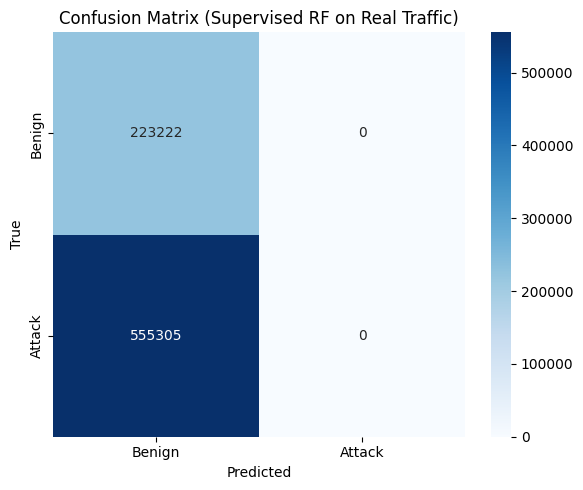

In [7]:
# === Metrics ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Attack"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Supervised RF on Real Traffic)")
plt.tight_layout()
plt.show()

## 2. Balancing with SMOTE and Retraining

To correct class imbalance in the dataset, SMOTE is used to oversample attack samples in the training set.  
A new Random Forest is trained on the balanced data using `class_weight="balanced"`. Performance is re-evaluated on the original test set to validate improvements in detection recall and reduction of bias.


In [8]:
# === Split data ===
X = combined_df.drop(columns=['attack'])
y = combined_df['attack'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === Apply SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_resampled.value_counts()}")


Before SMOTE: attack
1    444244
0    178577
Name: count, dtype: int64
After SMOTE: attack
0    444244
1    444244
Name: count, dtype: int64


In [9]:
# === Train Random Forest with class weight adjustment ===
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=1)
rf.fit(X_resampled, y_resampled)

# === Evaluate the model ===
y_pred_resampled = rf.predict(X_test)

print("Classification Report on Resampled Data:")
print(classification_report(y_test, y_pred_resampled, target_names=["Benign", "Attack"]))


Classification Report on Resampled Data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     44645
      Attack       1.00      1.00      1.00    111061

    accuracy                           1.00    155706
   macro avg       1.00      1.00      1.00    155706
weighted avg       1.00      1.00      1.00    155706



## 3. Threshold Optimization on Probabilities

The model's predicted probabilities are used to compute performance at 50 thresholds ranging from 0 to 1.  
This allows tuning the decision boundary based on precision, recall, and F1-score trade-offs.  
The threshold yielding the highest F1-score is selected and used to generate new predictions. Final metrics and a confusion matrix are plotted to visualize the result.


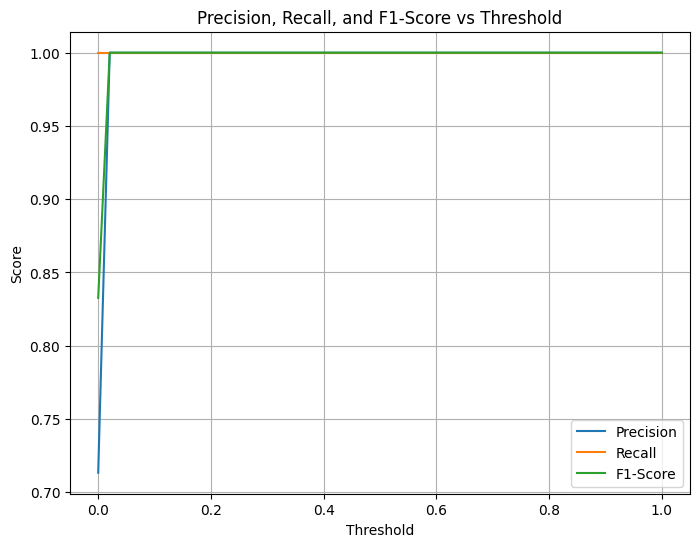

Best Threshold: 0.02040816326530612


In [10]:
# Get anomaly scores for threshold sweep
y_scores = rf.predict_proba(X_test)[:, 1]


# === Try different thresholds ===
thresholds = np.linspace(0, 1, 50)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_scores >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_threshold))
    recalls.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# === Plot the metrics against thresholds ===
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the best threshold (max F1-score)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_threshold}")


Optimized Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     44645
      Attack       1.00      1.00      1.00    111061

    accuracy                           1.00    155706
   macro avg       1.00      1.00      1.00    155706
weighted avg       1.00      1.00      1.00    155706



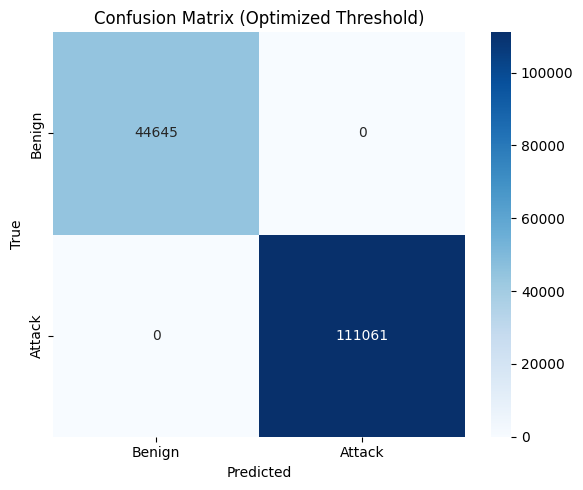

In [11]:
# === Apply the best threshold ===
y_pred_optimized = (y_scores >= best_threshold).astype(int)

# === Metrics and confusion matrix ===
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=["Benign", "Attack"]))

cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Optimized Threshold)")
plt.tight_layout()
plt.show()


## 4. Save Final Model

The trained and tuned Random Forest model is saved to disk in a designated directory.  
This preserves the exact model configuration used during evaluation and allows consistent deployment for future inference.


In [12]:
# Ensure the folder exists
model_dir = '../../models/5_supervised_real_traffic_test'
os.makedirs(model_dir, exist_ok=True)

# Save the trained Random Forest model to the new directory
model_save_path = os.path.join(model_dir, 'model.joblib')
joblib.dump(rf, model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at ../../models/5_supervised_real_traffic_test/model.joblib
